In [ ]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import matplotlib.pyplot as plt

# Acquire Data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Normalize training and test sets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_unormalized = transforms.Compose(
    [transforms.ToTensor()])


batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

trainset_unormalized = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_unormalized)
trainloader_unormalized = torch.utils.data.DataLoader(trainset_unormalized, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

testset_unormalized = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_unormalized)
testloader_unormalized = torch.utils.data.DataLoader(testset_unormalized, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Implementation

## Activation Functions and their Derivatives

In [ ]:
# Identity Function
identity = lambda z: z
der_identity = lambda z: 1

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))
der_logistic = lambda z: logistic(z)(1-logistic(z))

# Hyperbolic Tangent
tanh = lambda z: 2.*logistic(z)-1
der_tanh = lambda z: 1 - (tanh(z))**2

# ReLU
relu = lambda z: np.maximum(0., z)
der_relu = lambda z: np.heaviside(z, 0)

# Leaky ReLU
leaky_relu = lambda z, gamma=0.01: np.maximum(0., z) + gamma*np.minimum(0., z)
der_leaky_relu = lambda z, gamma=0.01: 1.0*(z > 0) + gamma*(z <= 0)

## Softmax Cross Entropy

In [ ]:
def softmax_cross_entropy(x,y,weights,act_fun=relu):
    ind = len(weights)
    if(ind == 1):
        w = weights[0]
        u = np.dot(x, w)
        yh = softmax(u)#N
        nll =  - np.mean(np.sum(u*y,1) - logsumexp(u))
        # nll =  - np.mean(np.sum(yh*y,1) - logsumexp(yh))
        return nll
    if(ind == 2):
        v1, w = weights
        z = act_fun(np.dot(x, v1)) #N x M
        u = np.dot(z, w)
        yh = softmax(u)#N
        nll =  - np.mean(np.sum(u*y,1) - logsumexp(u))
        # nll =  - np.mean(np.sum(yh*y,1) - logsumexp(yh))
        return nll
    if(ind == 3):
        v1, v2, w = weights
        z1 = act_fun(np.dot(x, v1)) #N x M
        z2 = act_fun(np.dot(z1, v2)) #N x M
        u = np.dot(z2, w)
        yh = softmax(u)#N
        u = np.array(u)
        nll =  - np.mean(np.sum(u*y,1) - logsumexp(u))
        # nll =  - np.mean(np.sum(yh*y,1) - logsumexp(yh))
        return nll

def cross_entropy_loss(y, yh):
    nll =  - np.mean(np.sum(yh*y, 1) - logsumexp(yh))
    return nll 

## Optimizers

### Gradient Descent

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.0001, max_iters=1000, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, weights):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, weights)
            for p in range(len(weights)):
                weights[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return weights

### Mini Batch Stochastic Gradient Descent

In [ ]:
import copy

class MiniBatch_SGD:
    
    def __init__(self, learning_rate=.0001, batch_size=16, n_epochs=2, epsilon=1e-8, record_history=True, verbose=True, early_stop=True):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.record_history = record_history
        self.verbose = verbose
        self.early_stop = early_stop

        if record_history:
            self.w_history = []       # to store the weight history for visualization
            self.cost_history = []

    def run(self, gradient_fn, x, y, weights, cost_fn=softmax_cross_entropy, act_fn=relu):
        N, D = x.shape 
        if self.record_history:
            self.w_history = []       # to store the weight history for visualization
            self.cost_history = []  

        # norms = np.array([np.inf])
        prev_cost = float("inf")
        prev_weights = copy.copy(weights)
        stop =  False
        num_iterations = 0

        post_stop_count = 0

        for epoch in range(self.n_epochs):
          # Shuffle dataframe
          perm = np.random.permutation(N)
          x_random = x[perm]
          y_random = y[perm]


          # Go through entire dataset taking step size of batch_size
          for i in range(0, N, self.batch_size):
            x_batch = x_random[i:i+self.batch_size]
            y_batch = y_random[i:i+self.batch_size]

            grad = gradient_fn(x_batch, y_batch, weights)
            for p in range(len(weights)):
                weights[p] -= self.learning_rate * grad[p]

          num_iterations+=1

          cost = cost_fn(x_random, y_random, weights, act_fn)
          print(cost)

          if(self.early_stop):
            if prev_cost < cost:
              print("STOP")
              stop = True
              weights = prev_weights
              break
            else:
              prev_cost = cost
              prev_weights = copy.copy(weights)
          else:
            if prev_cost < cost and post_stop_count==0:
              print("Early stop enocuntered, running 10 more times")
              stop = True
              post_stop_count+= 1
            elif post_stop_count > 0:
              post_stop_count+=1
              if(post_stop_count==10):
                break
            else:
              prev_cost = cost
              prev_weights = copy.copy(weights)

          if self.record_history:
              self.w_history.append(weights)

          if self.record_history:
              self.cost_history.append(cost)
          
        if self.record_history:
            print("Cost History: ")
            print("****************************************************************************")
            print(self.cost_history)
            print("****************************************************************************")

        if self.verbose:
            if stop == False:
              print(f'Ran through all {self.n_epochs} epochs, final cost: {cost}')
            else:
              print(f'Stopped after {num_iterations} epochs, final cost: {prev_cost}')

        return weights

## MLP

In [ ]:
# Dijian's version of MLP
class MLP():
    
    def __init__(self, act_fun = relu, derivative_act_fun = der_relu, num_hidden_layers = 2, num_units = [64, 64], bias = True, learning_rate = 0.0001, batch_size = 16, n_epochs = 100, regularization=None, lambdaa=1, early_stop=True):
        self.num_units = num_units
        self.num_hidden_layers = num_hidden_layers
        self.bias = bias
        self.act_fun = act_fun
        self.D_act_fun = derivative_act_fun
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.regularization = regularization
        self.lambdaa = lambdaa
        self.weights_his = []
        self.cost_his = []
        self.early_stop = early_stop

        if(self.bias and num_units is not None):
            for i in range(len(self.num_units)):
                self.num_units[i] = num_units[i]+1

        # every index of self.weights is a different weight per layer (ex: index 0 -> V, index 1-> W)
        self.weights = []


    def fit(self, x, y):
        # Optimizer is Mini Batch SGD
        optimizer = MiniBatch_SGD(learning_rate=self.learning_rate, batch_size=self.batch_size, n_epochs=self.n_epochs, early_stop=self.early_stop)
        if(self.bias):
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N,D = x.shape
        _, C = y.shape

        def gradient(x2, y, params):
            dparams = []
            N2 = x2.shape[0]
            if(self.num_hidden_layers == 0):
                w = params[0]
                yh = softmax(np.dot(x2, w))#N
                dy = yh - y #N
                if self.regularization=="l1":
                    dw = np.dot(x2.T, dy)/N2 #M
                    dw[1:] += self.lambdaa * np.sign(w[1:])
                elif self.regularization=="l2":
                    dw = np.dot(x2.T, dy)/N2 #M
                    dw[1:] += self.lambdaa * w[1:]
                else:
                    dw = np.dot(x2.T, dy)/N2 #M
                dparams = [dw]

            if(self.num_hidden_layers == 1):
                v1, w = params
                z = self.act_fun(np.dot(x2, v1)) #N x M
                z = np.array(z, dtype=np.float64)
                yh = softmax(np.dot(z, w))#N
                dy = yh - y #N

                dw = np.dot(z.T, dy)/N2 #M
                if self.regularization=="l1":
                    dw[1:] += self.lambdaa * np.sign(w[1:])
                elif self.regularization=="l2":
                    dw[1:] += self.lambdaa * w[1:]

                dz = np.dot(dy, w.T) #N x M
                dz = np.array(dz, dtype=np.float64)
                # derivative
                dv = np.dot(x2.T, dz * self.D_act_fun(z))/N2 #D x M

                if self.regularization=="l1":
                    dv[1:] += self.lambdaa * np.sign(v1[1:])
                elif self.regularization=="l2":
                    dv[1:] += self.lambdaa * v1[1:]
                    
                dv = np.array(dv, dtype=np.float64)
                dparams = [dv, dw]

            if(self.num_hidden_layers == 2):
                v1, v2, w = params
                z1 = self.act_fun(np.dot(x2, v1)) #N x M
                z2 = self.act_fun(np.dot(z1, v2)) #N x M
                yh = softmax(np.dot(z2, w))#N
                dy = yh - y #N
                dw = np.dot(z2.T, dy)/N2 #M

                if self.regularization=="l1":
                    dw[1:] += self.lambdaa * np.sign(w[1:])
                elif self.regularization=="l2":
                    dw[1:] += self.lambdaa * w[1:]

                dz2 = np.dot(dy, w.T) #N x M
                dz2 = np.array(dz2, dtype=np.float64)
                # derivative
                dv2 = np.dot(z1.T, dz2 * self.D_act_fun(z2))/N2 #M x M

                if self.regularization=="l1":
                    dv2[1:] += self.lambdaa * np.sign(v2[1:])
                elif self.regularization=="l2":
                    dv2[1:] += self.lambdaa * v2[1:]

                dz1 = np.dot(dz2, v2) * self.D_act_fun(z1)
                dv1 = np.dot(x2.T, dz1)/N2

                if self.regularization=="l1":
                    dv1[1:] += self.lambdaa * np.sign(v1[1:])
                elif self.regularization=="l2":
                    dv1[1:] += self.lambdaa * v1[1:]

                dparams = [dv1, dv2, dw]

            self.weights_his = optimizer.w_history
            self.cost_his = optimizer.cost_history
            return dparams

        if(self.num_hidden_layers == 0):
            w = np.random.randn(D, C) * .01
            self.weights.append(w)

        if(self.num_hidden_layers == 1):
            w = np.random.randn(self.num_units[0], C) * .01
            v1 = np.random.randn(D,self.num_units[0]) * .01
            self.weights.append(v1)
            self.weights.append(w)

        if(self.num_hidden_layers == 2):
            w = np.random.randn(self.num_units[1],C) * .01
            v2 = np.random.randn(self.num_units[0],self.num_units[1]) * .01
            v1 = np.random.randn(D,self.num_units[0]) * .01
            self.weights.append(v1)
            self.weights.append(v2)
            self.weights.append(w)

        
        self.weights = optimizer.run(gradient, x, y, self.weights)
        return self
    
    def predict(self, x):
        if(self.bias):
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            
        if(self.num_hidden_layers == 0):
            w = self.weights[0]
            yh = softmax(np.dot(x, w))#N
            return yh
        if(self.num_hidden_layers == 1):
            v1, w = self.weights
            z = self.act_fun(np.dot(x, v1)) #N x M
            yh = softmax(np.dot(z, w))#N
            return yh
        if(self.num_hidden_layers == 2):
            v1, v2, w = self.weights
            z1 = self.act_fun(np.dot(x, v1)) #N x M
            z2 = self.act_fun(np.dot(z1, v2)) #N x M
            yh = softmax(np.dot(z2, w))#N
            return yh

    def evaluate_acc(self, y, yh):
      y_classes = np.argmax(y, axis=1)
      yh_classes = np.argmax(yh, axis=1)    
      if len(y_classes) != len(yh_classes):
        raise ValueError("Y arrays must have the same length.")
      total_vals = len(y_classes)
      num_correctly_classified = 0
      for i in range(len(y_classes)):
        if(y_classes[i] == yh_classes[i]): 
          num_correctly_classified += 1
      accuracy = num_correctly_classified/total_vals
      print("Accuracy: ", accuracy)
      return accuracy

    def set_params(self, **params):
      if 'act_fun' in params:
        self.act_fun = params['act_fun']
      if 'derivative_act_fun' in params:
        self.D_act_fun = params['derivative_act_fun']
      if 'num_hidden_layers' in params:
        self.num_hidden_layers = params['num_hidden_layers']
      if 'learning_rate' in params:
        self.learning_rate = params['learning_rate']
      if 'batch_size' in params:
        self.batch_size = params['batch_size']
      if 'n_epochs' in params:
        self.n_epochs = params['n_epochs']
      return self
  

# Data Preprocessing and Analysis

In [ ]:
train_x = []
train_y = []
columnsY = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        input = torch.flatten(inputs, 1)
        
        train_x.append(input)
        train_y.append(labels)

train_x = torch.cat(train_x, dim=0)
train_y = torch.cat(train_y, dim=0)
train_y = pd.get_dummies(data=train_y, columns=columnsY).to_numpy()

test_x = []
test_y = []
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        input = torch.flatten(inputs, 1)
        
        test_x.append(input)
        test_y.append(labels)

test_x = torch.cat(test_x, dim=0)
test_y = torch.cat(test_y, dim=0)
test_y = pd.get_dummies(data=test_y, columns=columnsY).to_numpy()

train_x_unormalized = []
train_y_unormalized = []
for i, data in enumerate(trainloader_unormalized, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        input = torch.flatten(inputs, 1)
        
        train_x_unormalized.append(input)
        train_y_unormalized.append(labels)

train_x_unormalized = torch.cat(train_x_unormalized, dim=0)
train_y_unormalized = torch.cat(train_y_unormalized, dim=0)
train_y_unormalized = pd.get_dummies(data=train_y_unormalized, columns=columnsY).to_numpy()

test_x_unormalized = []
test_y_unormalized = []
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        input = torch.flatten(inputs, 1)
        
        test_x_unormalized.append(input)
        test_y_unormalized.append(labels)

test_x_unormalized = torch.cat(test_x_unormalized, dim=0)
test_y_unormalized = torch.cat(test_y_unormalized, dim=0)
test_y_unormalized = pd.get_dummies(data=test_y_unormalized, columns=columnsY).to_numpy()

In [ ]:
num_airplanes = np.sum(train_y[:, 0])
print("Number of images of Airplanes:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 1])
print("Number of images of Automobiles:\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 2])
print("Number of images of Bird:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 3])
print("Number of images of Cat:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 4])
print("Number of images of Deer:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 5])
print("Number of images of Dog:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 6])
print("Number of images of Frog:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 7])
print("Number of images of Horse:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 8])
print("Number of images of Ship:\t\t ", num_airplanes)
num_automobiles = np.sum(train_y[:, 9])
print("Number of images of Truck:\t\t ", num_airplanes)

Number of images of Airplanes:		  5000
Number of images of Automobiles:	  5000
Number of images of Bird:		  5000
Number of images of Cat:		  5000
Number of images of Deer:		  5000
Number of images of Dog:		  5000
Number of images of Frog:		  5000
Number of images of Horse:		  5000
Number of images of Ship:		  5000
Number of images of Truck:		  5000


In [ ]:
num_airplanes = np.sum(test_y[:, 0])
print("Number of images of Airplanes:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 1])
print("Number of images of Automobiles:\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 2])
print("Number of images of Bird:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 3])
print("Number of images of Cat:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 4])
print("Number of images of Deer:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 5])
print("Number of images of Dog:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 6])
print("Number of images of Frog:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 7])
print("Number of images of Horse:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 8])
print("Number of images of Ship:\t\t ", num_airplanes)
num_automobiles = np.sum(test_y[:, 9])
print("Number of images of Truck:\t\t ", num_airplanes)

# Hyperparameter Tuning

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MLP_Estimator(BaseEstimator, ClassifierMixin):
  
  def __init__(self, act_fun = relu, derivative_act_fun = der_relu, num_hidden_layers = 2, num_units = [64, 64], bias = True, learning_rate = 0.0001, batch_size = 16, n_epochs = 100):
    self.model = MLP(act_fun, derivative_act_fun, num_hidden_layers, num_units, bias, learning_rate, batch_size, n_epochs)
    # super().__init__(act_fun, derivative_act_fun, num_hidden_layers, num_units, bias, learning_rate, batch_size, n_epochs)

  def get_params(self, deep=True):
    return {'act_fun': self.model.act_fun, 
            'derivative_act_fun': self.model.D_act_fun, 
            'num_hidden_layers': self.model.num_hidden_layers,
            'num_units': self.model.num_units,
            'learning_rate': self.model.learning_rate,
            'batch_size': self.model.batch_size,
            'n_epochs': self.model.n_epochs}

  def set_params(self, **params):
    # print(help(self.model.set_params))
    # print(*params)
    self.model.set_params(params=params)
    return self

  def fit(self, x, y):
    return self.model.fit(x, y)
  
  def predict(self, x):
    return self.model.predict(x)

  def score(self, x, y):
    yh = self.predict(x)
    score = self.model.evaluate_acc(y, yh)
    return score

In [ ]:
def MLP_score(est, x, y):
  yh = est.predict(x)
  score = est.evalutate_acc(y, yh)
  if np.isnan(score):
    raise ValueError("SCORE IS NAN")
  return score

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1],
              'batch_size': [16, 32, 64, 128],
              'n_epochs': [10, 50, 100, 1000]}
MLP_estimator = MLP_Estimator()
grid_cv = GridSearchCV(estimator=MLP_estimator, param_grid=param_grid, refit=False, verbose=100, error_score='raise')
random_cv = RandomizedSearchCV(estimator=MLP_estimator, param_distributions=param_grid, refit=False, verbose=100, error_score='raise')

In [ ]:
search = random_cv.fit(test_x, test_y)
search.best_params_
print(search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START batch_size=64, learning_rate=0.001, n_epochs=10............
11.289698273815064
11.289696026522051
11.289693777410536
11.289691516253933
11.289689242369244
11.2896869589156
11.28968466156836
11.289682353280451
11.289680021197062
11.28967766504111
11.289675296760992
11.289672912500842
11.289670495644275
11.28966805588094
11.289665598474317
11.289663123698134
11.289660626046668
11.289658108167181
11.289655576476921
11.289653022312764
11.289650441036116
11.28964783089832
11.28964518996984
11.289642515611359
11.289639803977733
11.289637053740792
11.289634270912309
11.28963145141658
11.289628595105729
11.289625708357184
11.289622785154785
11.289619822490652
11.289616811956538
11.289613750446238
11.289610649140311
11.289607503676931
11.289604316666694
11.28960107617712
11.289597782472567
11.289594446639123
11.289591064304089
11.28958763132991
11.289584151743075
11.289580611427962
11.289577013773933
11.2895733623

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-9b8684f38bef>", line 1, in <module>
    search = random_cv.fit(test_x, test_y)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py", line 1768, in _run_search
    evaluate_candidates(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.9/dist-packages/joblib/parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  Fi

KeyboardInterrupt: ignored

**Random Search CV:**



> **Result (best params)**: {'learning_rate': 0.0001, 'batch_size': 16}



# Experiments

## 3 MLP Models without early stop

In [ ]:
MLP0 = MLP(act_fun=None,
           derivative_act_fun=None, 
           num_hidden_layers=0, 
           num_units=None, 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 50,
           early_stop=False)
MLP1 = MLP(act_fun=relu,
           derivative_act_fun=der_relu, 
           num_hidden_layers=1, 
           num_units=[256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 50,
           early_stop=False)
MLP2 = MLP(act_fun=relu,
           derivative_act_fun=der_relu, 
           num_hidden_layers=2, 
           num_units=[256, 256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 50,
           early_stop=False)

MLP0_fit = MLP0.fit(train_x, train_y)
yh0_train = MLP0_fit.predict(train_x)
yh0_test = MLP0_fit.predict(test_x)

MLP1_fit = MLP1.fit(train_x, train_y)
yh1_train = MLP1_fit.predict(train_x)
yh1_test = MLP1_fit.predict(test_x)

MLP2_fit = MLP2.fit(train_x, train_y)
yh2_train = MLP2_fit.predict(train_x)
yh2_test = MLP2_fit.predict(test_x)

## Cost vs Epoch

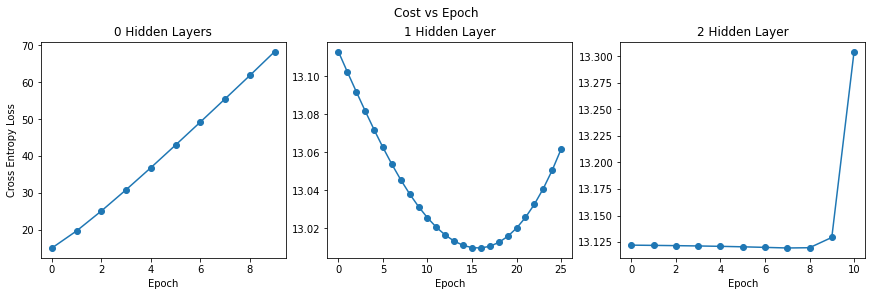

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(12, 4))

cost_h0 = [15.056937714509393, 19.711722466466767, 25.116074972351832, 30.878830953309294, 36.861259490296085, 43.012906744520805, 49.24088998295954, 55.53512024279553, 61.87081081074301, 68.32863924224073]
cost_h1 = [13.113086583377292, 13.102426002441586, 13.092060835511411, 13.08188430256366, 13.072010844882426, 13.062599343013106, 13.053754698120631, 13.045558530599328, 13.038089067407489, 13.031402135917833, 13.025538473372785, 13.020537894476636, 13.016430378553185, 13.013251689652146, 13.011037450714364, 13.00982248176176, 13.00964386062743, 13.010543124947306, 13.012558211335511, 13.015731709089104, 13.020112093859774, 13.025740539790785, 13.032666634118902, 13.040936208130175, 13.050596246613091, 13.06171031944963]
cost_h2 = [13.122056165553708, 13.121832686306284, 13.12158073861722, 13.1212860949769, 13.120929035343577, 13.120486962495022, 13.119945922774304, 13.119377103722156, 13.119622934313957, 13.129324622882132, 13.304515114424616]

fig.suptitle('Cost vs Epoch')

axes[0].set_title("0 Hidden Layers")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].scatter(range(len(cost_h0)), cost_h0)
axes[0].plot(range(len(cost_h0)), cost_h0)

axes[1].set_title("1 Hidden Layer")
axes[1].set_xlabel("Epoch")
axes[1].scatter(range(len(cost_h1)), cost_h1)
axes[1].plot(range(len(cost_h1)), cost_h1)

axes[2].set_title("2 Hidden Layer")
axes[2].set_xlabel("Epoch")
axes[2].scatter(range(len(cost_h2)), cost_h2)
axes[2].plot(range(len(cost_h2)), cost_h2)

plt.show()

## 3.1 Run on 3 different models

In [ ]:
MLP0 = MLP(act_fun=None,
           derivative_act_fun=None, 
           num_hidden_layers=0, 
           num_units=None, 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 100)
MLP1 = MLP(act_fun=relu,
           derivative_act_fun=der_relu, 
           num_hidden_layers=1, 
           num_units=[256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 100)
MLP2 = MLP(act_fun=relu,
           derivative_act_fun=der_relu, 
           num_hidden_layers=2, 
           num_units=[256, 256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 100)

yh0 = MLP0.fit(train_x, train_y).predict(test_x)
yh1 = MLP1.fit(train_x, train_y).predict(test_x)
yh2 = MLP2.fit(train_x, train_y).predict(test_x)

acc0 = MLP0.evaluate_acc(test_y, yh0)
acc1 = MLP1.evaluate_acc(test_y, yh1)
acc2 = MLP2.evaluate_acc(test_y, yh2)

15.035935761143078
19.66034090406464
STOP
Cost History: 
****************************************************************************
[15.035935761143078]
****************************************************************************
Stopped after 2 epochs, final cost: 15.035935761143078
13.09890402914657
13.074509201674227
14.015834837319476
STOP
Cost History: 
****************************************************************************
[13.09890402914657, 13.074509201674227]
****************************************************************************
Stopped after 3 epochs, final cost: 13.074509201674227
13.121795116859067
13.121533366471606
13.12123680864229
13.120887047265173
13.12046096152601
13.119927970354697
13.119246315370711
13.118372079112818
13.117348813286538
13.117000866304698
13.12627006926209
STOP
Cost History: 
****************************************************************************
[13.121795116859067, 13.121533366471606, 13.12123680864229, 13.120887047265173, 13.12

## 3.2 Try with tanh and Leaky-ReLU

In [ ]:
MLP_tanh = MLP(act_fun=tanh,
           derivative_act_fun=der_tanh, 
           num_hidden_layers=2, 
           num_units=[256, 256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 100)

MLP_tanh_fit = MLP_tanh.fit(train_x, train_y)
yh_tanh_train = MLP_tanh_fit.predict(train_x)
yh_tanh_test = MLP_tanh_fit.predict(test_x)
acc_tanh_train = MLP_tanh_fit.evaluate_acc(train_y, yh_tanh_train)
acc_tanh_test = MLP_tanh_fit.evaluate_acc(test_y, yh_tanh_test)
print("Train Accuracy: ", acc_tanh_train)
print("Test Accuracy: ", acc_tanh_test)

In [ ]:
MLP_leaky = MLP(act_fun=leaky_relu,
           derivative_act_fun=der_leaky_relu, 
           num_hidden_layers=2, 
           num_units=[256, 256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 100)
MLP_leaky_fit = MLP_leaky.fit(train_x, train_y)
yh_leaky_train = MLP_leaky_fit.predict(train_x)
yh_leaky_test = MLP_leaky_fit.predict(test_x)
acc_leaky_train = MLP_leaky_fit.evaluate_acc(train_y, yh_leaky_train)
acc_leaky_test = MLP_leaky_fit.evaluate_acc(test_y, yh_leaky_test)
print("Train Accuracy: ", acc_leaky_train)
print("Test Accuracy: ", acc_leaky_test)

## Evaluate Effect of Width

In [ ]:
# [16, 16]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[16,16], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [16,16] has accuracy: ", acc)

In [ ]:
# [32, 32]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[32,32], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [32,32] has accuracy: ", acc)

In [ ]:
# [64, 64]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[64,64], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [64,64] has accuracy: ", acc)

In [ ]:
# [128, 128]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[128,128], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [128,128] has accuracy: ", acc)

In [ ]:
# [256, 256]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[256,256], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [256,256] has accuracy: ", acc)

In [ ]:
# [512, 512]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[512,512], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [512,512] has accuracy: ", acc)

In [ ]:
# [1024, 1024]
MLP = MLP(act_fun=relu,
          derivative_act_fun=der_relu, 
          num_hidden_layers=2, 
          num_units=[1024,1024], 
          learning_rate=0.0001, 
          batch_size=16, 
          n_epochs = 100)
yh = MLP.fit(train_x, train_y).predict(test_x)
acc = MLP.evaluate_acc(test_y, yh)
print("Width [1024,1024] has accuracy: ", acc)

In [ ]:
# With ReLU
accuracies = [0.1, 0.117, 0.1061, 0.1027, 0.1013, 0.2189, 0.1494]
num_units = [16, 32, 64, 128, 256, 512, 1024]

colors = ['r','g', 'b', 'm', 'y', 'c', 'k']

f = plt.figure()
f.set_figwidth(10)

for i in range(len(num_units)):
  plt.plot(num_units[i], accuracies[i], '.', markersize=10, markeredgecolor=colors[i], markerfacecolor=colors[i], label=(f'units per layer = {num_units[i]}'))

plt.title("Accuracy vs Number of Units")
plt.legend()
plt.show()

## 3.3 L1 and L2 Regularization

In [ ]:
las = [1,0,0.1]
acc1 = []
acc2 = []
# gradient with L1 regularization
for la in las:
    temp = []
    MLP_l1 = MLP(act_fun=relu,
              derivative_act_fun=der_relu, 
              num_hidden_layers=2, 
              num_units=[256, 256], 
              learning_rate=0.0001, 
              batch_size=16, 
              n_epochs = 100,
              regularization = "l1")
    yh_l1 = MLP_l1.fit(train_x, train_y).predict(test_x)
    acc_l1 = MLP_l1.evaluate_acc(test_y, yh_l1)
    print("accuracy for l1 with lambda (", la, "): ",acc_l1)

    acc1.append(MLP_l1.cost_his)

# gradient with L2 regularization
for la in las:
    MLP_l2 = MLP(act_fun=relu,
              derivative_act_fun=der_relu, 
              num_hidden_layers=2, 
              num_units=[256, 256], 
              learning_rate=0.0001, 
              batch_size=16, 
              n_epochs = 100,
              regularization = "l2",
              lambdaa=la)
    yh_l2 = MLP_l2.fit(train_x, train_y).predict(test_x)
    acc_l2 = MLP_l2.evaluate_acc(test_y, yh_l2)
    print("accuracy for l2 with lambda (", la, "): ",acc_l2)
    acc2.append(MLP_l2.cost_his)



13.122363390039958
13.122363382189542
13.12236338948376
STOP
Cost History: 
****************************************************************************
[13.122363390039958, 13.122363382189542]
****************************************************************************
Stopped after 3 epochs, final cost: 13.122363382189542
Accuracy:  0.1218
accuracy for l1 with lambda ( 1 ):  0.1218
13.122363374629389
13.12236338130905
STOP
Cost History: 
****************************************************************************
[13.122363374629389]
****************************************************************************
Stopped after 2 epochs, final cost: 13.122363374629389
Accuracy:  0.0892
accuracy for l1 with lambda ( 0 ):  0.0892
13.122363366697494
13.122363369652517
STOP
Cost History: 
****************************************************************************
[13.122363366697494]
****************************************************************************
Stopped after 2 epochs, final co

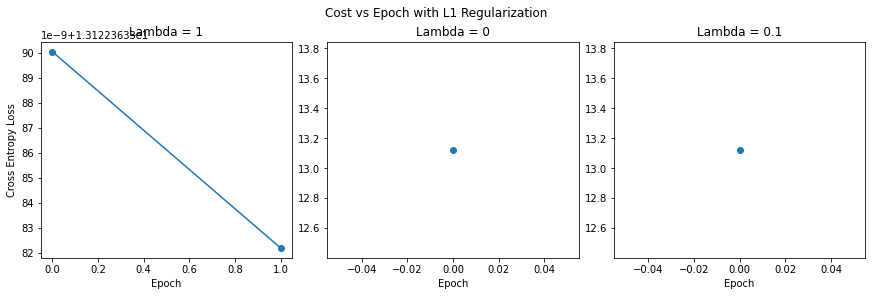

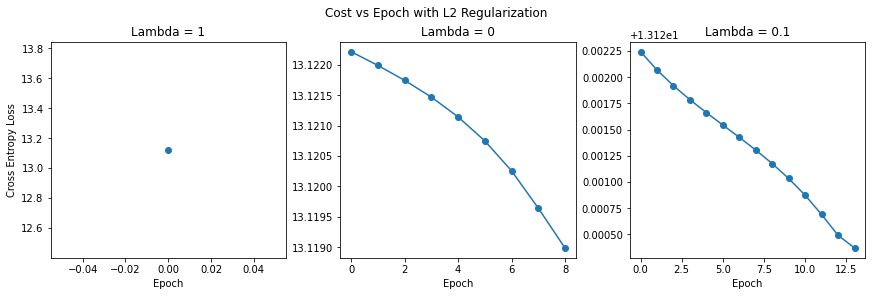

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(12, 4))

cost_h0 = acc1[0]
cost_h1 = acc1[1]
cost_h2 = acc1[2]

fig.suptitle('Cost vs Epoch with L1 Regularization')

axes[0].set_title("Lambda = 1")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].scatter(range(len(cost_h0)), cost_h0)
axes[0].plot(range(len(cost_h0)), cost_h0)

axes[1].set_title("Lambda = 0")
axes[1].set_xlabel("Epoch")
axes[1].scatter(range(len(cost_h1)), cost_h1)
axes[1].plot(range(len(cost_h1)), cost_h1)

axes[2].set_title("Lambda = 0.1")
axes[2].set_xlabel("Epoch")
axes[2].scatter(range(len(cost_h2)), cost_h2)
axes[2].plot(range(len(cost_h2)), cost_h2)

plt.show()

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(12, 4))

cost_h0 = acc2[0]
cost_h1 = acc2[1]
cost_h2 = acc2[2]

fig.suptitle('Cost vs Epoch with L2 Regularization')

axes[0].set_title("Lambda = 1")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].scatter(range(len(cost_h0)), cost_h0)
axes[0].plot(range(len(cost_h0)), cost_h0)

axes[1].set_title("Lambda = 0")
axes[1].set_xlabel("Epoch")
axes[1].scatter(range(len(cost_h1)), cost_h1)
axes[1].plot(range(len(cost_h1)), cost_h1)

axes[2].set_title("Lambda = 0.1")
axes[2].set_xlabel("Epoch")
axes[2].scatter(range(len(cost_h2)), cost_h2)
axes[2].plot(range(len(cost_h2)), cost_h2)

plt.show()

## 3.4 Unnormalized Images

In [ ]:
# train with unnormalized images

MLP_unormalized = MLP(act_fun=relu,
           derivative_act_fun=der_relu, 
           num_hidden_layers=2, 
           num_units=[256, 256], 
           learning_rate=0.0001, 
           batch_size=16, 
           n_epochs = 100)

yh_unormalized = MLP_unormalized.fit(train_x_unormalized, train_y_unormalized).predict(test_x_unormalized)

acc_unormalized = MLP_unormalized.evaluate_acc(test_y_unormalized, yh_unormalized)
print("Accuracy: ", acc_unormalized)

cost_his = MLP_unormalized.cost_his

13.122212345328604
13.122176734672943
13.122201204793244
STOP
Cost History: 
****************************************************************************
[13.122212345328604, 13.122176734672943]
****************************************************************************
Stopped after 3 epochs, final cost: 13.122176734672943
Accuracy:  0.1049
Accuracy:  0.1049


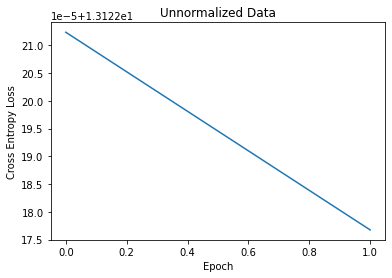

In [ ]:
plt.plot(range(len(MLP_unormalized.cost_his)),MLP_unormalized.cost_his)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Unnormalized Data')
plt.show()

## 3.5

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


# fetching the data using tensorset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize the data using tensorset
train_images, test_images = train_images / 255.0, test_images / 255.0

#creating convolutional base
model = models.Sequential()

#first and second layer for convolutional
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#simply flatten the data(not a layer)
model.add(layers.Flatten())

#last 2 layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

graph = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                3211328   
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 3,231,370
Trainable params: 3,231,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1563/1563 [======================

313/313 - 8s - loss: 2.7402 - accuracy: 0.6061 - 8s/epoch - 24ms/step
0.6061000227928162


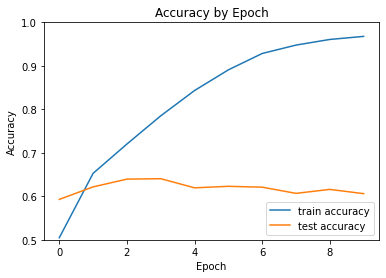

In [ ]:
#plot accuracy graph
plt.plot(graph.history['accuracy'], label='train accuracy')
plt.plot(graph.history['val_accuracy'], label = 'test accuracy')
plt.title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#accuracy percentage
loss, accuracy = model.evaluate(test_images,  test_labels, verbose=2)
print(accuracy)

## 3.6


Experiment with 2 connected layers.

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, Dense
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras import datasets
from keras.layers.core import Dense, Activation
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import MobileNetV2

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255, test_images / 255

shape = (32, 32, 3)

# pre-trained model with MobileNetV2
base_model = MobileNetV2(input_shape=shape, include_top=False, weights='imagenet')

#freeze everything from the pre-trained model
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False

# add layers
maxpool_layer = GlobalMaxPooling2D()
layer1 = Dense(units=256, activation='relu')
layer2 = Dense(units=10, activation='softmax')


model = Sequential([
    base_model,
    maxpool_layer,
    layer1,
    layer2
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["sparse_categorical_accuracy"])

hist= model.fit(train_images, train_labels, epochs=5)



9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
1563/1563 [==============================] - 203s 125ms/step - loss: 1.3763 - sparse_categorical_accuracy: 0.5306
Epoch 2/5
1563/1563 [==============================] - 184s 118ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.6331
Epoch 3/5
1563/1563 [==============================] - 181s 116ms/step - loss: 0.9932 - sparse_categorical_accuracy: 0.6631
Epoch 4/5
1563/1563 [==============================] - 183s 117ms/step - loss: 0.9311 - sparse_categorical_accuracy: 0.6833
Epoch 5/5
1563/1563 [==============================] - 181s 116ms/step - loss: 0.8783 - sparse_categorical_accuracy: 0.7028


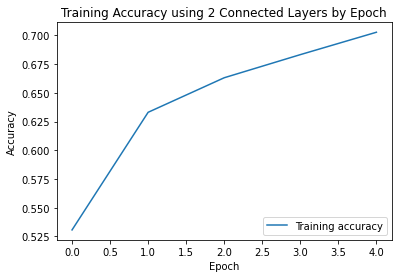

In [ ]:
#Plot graph1
plt.plot(hist.history['sparse_categorical_accuracy'], label="Training accuracy")
plt.legend(loc = "lower right")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training Accuracy using 2 Connected Layers by Epoch")
plt.show()

Experiment with 3 connected layers

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, Dense
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras import datasets
from keras.layers.core import Dense, Activation
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import MobileNetV2

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255, test_images / 255

shape = (32, 32, 3)
# Pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=shape, include_top=False, weights='imagenet')

#freeze everything from the pre-trained model
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False

# add layers
maxpool_layer = GlobalMaxPooling2D()
layer1 = Dense(units=512, activation='relu')
layer2 = Dense(units=256, activation='relu')
layer3 = Dense(units=10, activation='softmax')

#layer stacking
model = Sequential([
    base_model,
    maxpool_layer,
    layer1,
    layer2,
    layer3
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["sparse_categorical_accuracy"])

hist= model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
1563/1563 [==============================] - 193s 120ms/step - loss: 1.3567 - sparse_categorical_accuracy: 0.5401
Epoch 2/5
1563/1563 [==============================] - 188s 120ms/step - loss: 1.0881 - sparse_categorical_accuracy: 0.6345
Epoch 3/5
1563/1563 [==============================] - 188s 120ms/step - loss: 0.9926 - sparse_categorical_accuracy: 0.6667
Epoch 4/5
1563/1563 [==============================] - 189s 121ms/step - loss: 0.9246 - sparse_categorical_accuracy: 0.6903
Epoch 5/5
1563/1563 [==============================] - 188s 120ms/step - loss: 0.8529 - sparse_categorical_accuracy: 0.7121


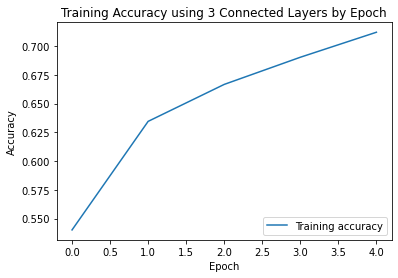

In [ ]:
#Plot graph2
plt.plot(hist.history['sparse_categorical_accuracy'], label="Training accuracy")
plt.legend(loc = "lower right")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training Accuracy using 3 Connected Layers by Epoch")
plt.show()